# Tutorial 1: Introduction to PyEOSim
#### Joe Fennell | September 2024
<br>

In this tutorial we'll use a hypothetical sensor with the spectral response function of the Sentinel 2A satellite. There are code examples to run and clearly-labelled 'Suggested Activities' throughout. You may not have time to complete all the suggested activities in the time available, but this resource will be permanently available to you.

It is recommended that you [read the introductory material here](https://github.com/joe-fennell/pangeos-training-24) before starting this tutorial.

## Notebook Contents
[1. Getting Started](#start)

[2. Conceptual Model](#conceptual)

[3. Spectral Response Functions](#spectral)

[4. Atmospheric Transformer](#atmosphere)

[5. TDI Imager](#imager)

<a id="start"></a>
## 1. Getting Started
Before you begin, please check that you have installed the required software using the instructions [here](PANGEOS24_Case_Study_3B_Pre_Workshop.pdf).

All of the course data are located on Google Drive and need to be downloaded before we can use them. Uncomment and run the cell below to download all the required data files for the course. The total is ~340 MB so may take a few minutes depending on the speed of your network connection.

**You only need to run this once for all the tutorials**

You can also run the downloader directly in a terminal window:

`> python get_course_data.py`


In [1]:
# Uncomment and run this tab to download course data (~340 MB)
import get_course_data

get_course_data.download()

All files downloaded to /Users/jf9942/github/pangeos-training-24/data


<a id="conceptual"></a>
## 2. Conceptual Model

The PyEOSim emulator carries out two discrete tasks:
1. Simulates the at-sensor (Top-Of-Atmosphere) radiance for each of the imager’s spectral channels.
2. Simulates the raw imager output from the at-sensor radiance for each of the imager’s spectral channels

The model is laid out in the diagram below:

<img src="src/PANGEOS24_Case_Study_3B_Handbook.svg" alt="Conceptual diagram" width="80%"/>

Both tasks require the instrument **Spectral Response Functions (SRFs)** to be defined in advance. These functions describe the imager’s spectral responses in each of the spectral channels. This is required for the scene generation so that the spectral downsampling is done at the earliest possible point and reduces the computational demands of the system.

Both tasks are carried out by classes that use fit and transform methods.
A fit method sets up an instance of the experiment.
A transform method generates a specific instance without re-initialising parameters that do not change from image to image.

In the case of the atmospheric simulation (pyeosim.SixSV_atmosphere class), calling fit generates coefficients for each spectral channel of the instrument. These map surface reflectance to top-of-atmosphere radiance. If you wished to understand the uncertainty of properties of the atmosphere (e.g. by drawing Atmospheric Aerosol Thickness from a distribution instead of using a fixed value), the fit method would be called each time you generate a new instance of the atmosphere. Once the model is fitted, the transform method is used to transform the input hyperspectral reflectance array into top-of-atmosphere radiance.

For the imager model, calling the fit method generates random instances of the Photo Response Non-Uniformity, the Dark Signal Non-Uniformity and the Column Offset Noise arrays. These are non-uniformity properties, caused by inherent differences across the sensor plane, that are generally considered fixed for a given imager (although changes do occur over long periods of time). The TDI model implementation in PyEOSim is a type of pushbroom sensor and so these non-uniformities are generated only along the x-axis of the input imagery (representing the physical columns of the sensor) and the acquisition direction is considered to be parallel to the y-axis. The fit method should only be called once per experimental run if there is interest in measuring the non-uniformity uncertainty. The transform method can be called for each new scene, for different atmospheres, or for measuring the uncertainty on downstream analyses.

<a id="spectral"></a>
## 3. Spectral Response Functions
The Spectral Response Functions (SRFs) are the normalised instrument sensitivities as a function of wavelength. These are the first things we set up because they are required for the SixsV atmospheric transformer and the Imager transformer.

In [2]:
from pyeosim import spectral
import xarray
import matplotlib.pyplot as plt

(400.0, 1000.0)

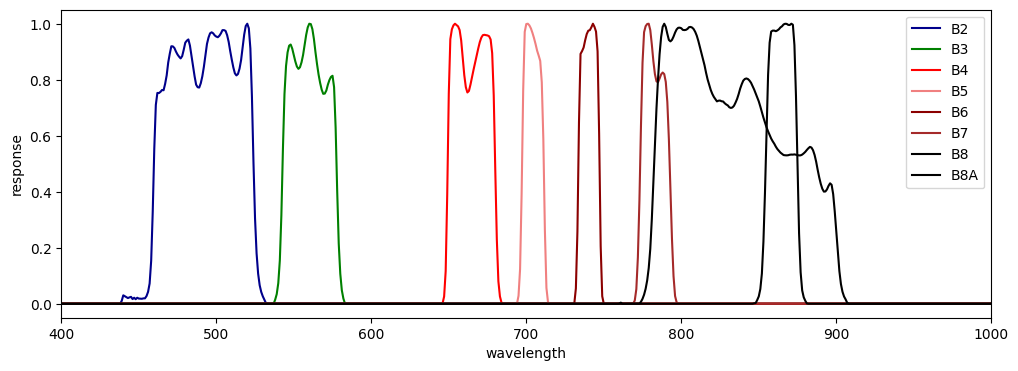

In [3]:
Sentinel2A_SRF = spectral.Sentinel2VNIR()

plot_colours = {
    'B2': 'darkblue',
    'B3': 'green',
    'B4': 'red',
    'B5': 'lightcoral',
    'B6': 'darkred',
    'B7': 'brown',
    'B8': 'k',
    'B8A': 'k',
    'B11': 'k',
    'B12': 'k'
}

f, a = plt.subplots(figsize=(12,4))

for name, response in Sentinel2A_SRF.srfs.items():
    response.plot(label=name, c=plot_colours[name])
plt.legend()
plt.xlim(400,1000)

current sensors available are `['Sentinel2A',
 'Sentinel2B',
 'Sentinel2VNIR',
 'SuperDove']`

If you need to define a new sensor, there's a few ways of doing this. For each new sensor, you should define a class that inherits from the base SRF class: `pyeosim.spectral._SRF`. If you're new to class inheritance, don't worry, there's an example layed out below.

When specifying the new SRF class, the only thing that is needed is to define the `_load_srfs` method. The method should do 3 things:
1. set the `band_names` property to a list. E.g. `['B2', 'B3', 'B4']`
2. set the `band_wavelengths` property to a dictionary with the central wavelength (or peak wavelength) defined for each band. E.g. `{'B2':490, 'B3':530, 'B4':620}`
3. return the spectral response functions. This is a dictionary of xarray.DataArrays or an xarray.Dataset with one item per band. The DataArray should have a wavelength coordinate and specify the wavelength response over all wavelengths that will be evaluated in your simulation

The easiest way is to define the spectral response as a step function using the central wavelength and bandwidth. You can also specify the maximum sensitivity (i.e. the peak height) but it is recommended that you set this to 1 and control the absolute wavelength sensitivity using the spectral quantum efficiency of the sensor (we will come back to this).

Text(0.5, 1.0, 'Custom Sensor Specification 1')

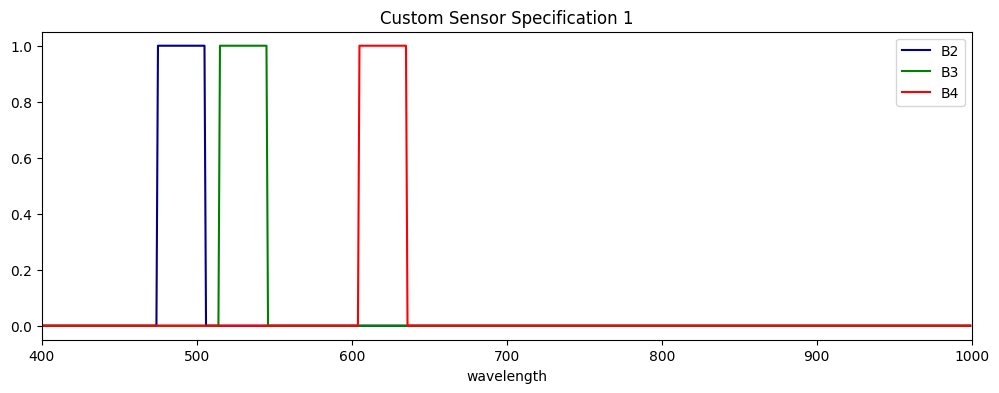

In [4]:
class MyNewSensor(spectral._SRF): # specifying the inherited base class spectral._SRF
    # we just need to define how the spectral response functions are generated.
    # In this example, they are generated from step functions
    def _load_srfs(self):
        # make a dictionary defining the wavelength centre in nm, 
        # band width in nm and maximum response (recommended to use 1)
        band_definitions = {
            'B2': (490, 30, 1),
            'B3': (530, 30, 1),
            'B4': (620, 30, 1)
        }
        
        self.band_names = list(band_definitions.keys())
        self.band_wavelengths = {k: v[0] for (k, v) in band_definitions.items()}
        
        return spectral.bands_from_step_func(band_definitions)

f, a = plt.subplots(figsize=(12,4))

for name, response in MyNewSensor().srfs.items():
    response.plot(label=name, c=plot_colours[name])
    plt.xlim(400,1000)
plt.legend()
plt.title('Custom Sensor Specification 1')

An alternative way is to load the arrays from a file (e.g. load from a CSV) but this isn't directly supported as there are lots of different ways spectral responses could be defined in CSV or NetCDF files. If we inspect the `srfs` attribute we can see it is a dictionary of DataArrays with each response function array keyed by its name:

In [5]:
Sentinel2A_SRF.srfs['B2']

<xarray.DataArray 'response' (wavelength: 2301)> Size: 18kB
array([0., 0., 0., ..., 0., 0., 0.])
Coordinates:
  * wavelength  (wavelength) int64 18kB 300 301 302 303 ... 2597 2598 2599 2600
Attributes:
    Band:     B2

Here is a further example with the response arrays generated directly, rather than using the step function

Text(0.5, 1.0, 'Custom Sensor Specification 2')

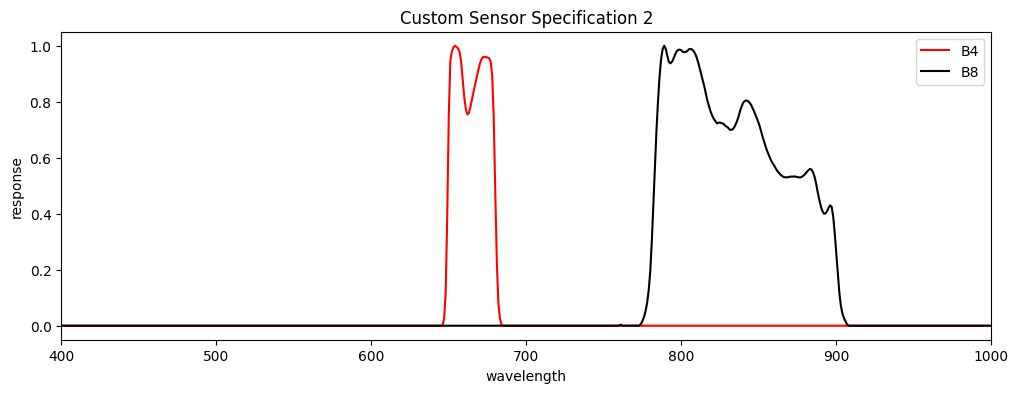

In [6]:
class Sentinel2A_NDVI(spectral._SRF): # specifying the inherited base class spectral._SRF
    # we just need to define how the spectral response functions are generated.
    # In this example, they are subset from Sentinel 2A
    def _load_srfs(self):
        # use the Sentinel 2A SRFs
        S2A_srfs = spectral.Sentinel2A().srfs
        
        srfs = {
            'B4': S2A_srfs['B4'],
            'B8': S2A_srfs['B8']
        }

        self.band_names = ['Red', 'NIR']
        self.band_wavelengths = {
            'B4': 664,
            'B8': 832
        }
        
        return srfs

f, a = plt.subplots(figsize=(12,4))

for name, response in Sentinel2A_NDVI().srfs.items():
    response.plot(label=name, c=plot_colours[name])
    plt.xlim(400,1000)
plt.legend()
plt.title('Custom Sensor Specification 2')

### Suggested Activity:

Generate an SRF class for an imager you're interested in, either with approximate bandpass responses (specified by step function) or with a dataloader

In [7]:
## Your SRF class here:

<a id="atmosphere"></a>
## 4. The Atmospheric Transformer

The atmospheric transformer accepts a reflectance spectrum as an input and generates the top-of-atmosphere radiance in each band. The `pyeosim.atmosphere.SixSV_atmosphere` is a wrapper for a SixS instance. All atmospheric generation is carried out by the SixS module.

We will first generate an atmosphere for the date and position of the Milton Keynes imagery.

In [8]:
import Py6S
import pyproj
from pyeosim import atmosphere
from datetime import datetime

In [9]:
# transform the coordinates from UTM to Lat/Lon
crs_transformer = pyproj.Transformer.from_crs('epsg:32630', 'epsg:4326')
position = (652145, 5763546) # top left corner of array

for pt in crs_transformer.itransform([position]):
    lat, lon = pt
    
print(lat,',', lon)

52.00169266100998 , -0.7835588288298042


We can write helper functions to generate atmospheres using specific parameterisations. There are many ways of generating the SixS atmospheres - full [documentation is available here](https://py6s.readthedocs.io/en/latest/index.html) - but in this case, we will model the ground as a homogeneous Lambertian diffuser with a sensor at nadir (looking directly down).

In [10]:
def generate_atmosphere(lat, lon, hour, day, month, view_a=0, view_z=0, SRF=None):
    
    OZONE = 0.00735 # central UK average from MODIS for March-September 2021
    AOT = 0.16 # typical UK summer Aerosol Optical Thickness
    # AOT = 1 # typical UK summer Aerosol Optical Thickness
    WVP = 1.37 # typical UK summer Water Vapour
    s = Py6S.SixS()
    
    s.altitudes.set_sensor_satellite_level()
    
    s.ground_reflectance = Py6S.GroundReflectance.HomogeneousLambertian(1)
    s.atmos_profile = Py6S.AtmosProfile().UserWaterAndOzone(WVP, OZONE)
    s.aot550 = AOT
    
    # setup the geometries
    s.geometry = Py6S.Geometry.User()
    s.geometry.from_time_and_location(
        lat,
        lon,
        datetime(2020, month, day, hour, 0).isoformat(),
        view_z,
        view_a)
    
    t = atmosphere.SixSV_atmosphere(s, SRF)
    return t

In [11]:
atmosphere_1 = generate_atmosphere(
    lat=lat,
    lon=lon,
    hour=13,
    day=22,
    month=6
)

as we didn't specify a spectral response function, we need to fit the model with one of our Spectral Response Functions. In this case, we'll use the Sentinel2 VNIR-only

In [12]:
atmosphere_1.fit(Sentinel2A_SRF)

we can check to see that the transform coefficients have been correctly generated:

In [13]:
atmosphere_1._coefs

<xarray.Dataset> Size: 256B
Dimensions:                 (band: 8)
Coordinates:
  * band                    (band) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    a                       (band) float64 64B 37.3 23.27 11.69 ... 4.816 4.122
    b                       (band) float64 64B 422.1 430.9 373.0 ... 251.5 246.9
    filter_integral_micron  (band) float64 64B 0.05851 0.03173 ... 0.01991

In order to try this on an actual scene, we need to load the Milton Keynes test scene and preprocess

In [14]:
# stored as uint16 but needs to be converted to fractional [0-1] reflectance for the atmospheric transformer
mk_vnir_reflectance = xarray.open_dataset('data/Milton_Keynes_aerial_VisVNIR.nc')['reflectance'] / 10000

# the dimension coordinate must be wavelength
mk_vnir_reflectance = mk_vnir_reflectance.swap_dims({'band': 'wavelength'})

This is a 186 channel Visible-VNIR hyperspectral reflectance dataset captured by an aircraft over Milton Keynes, UK.

This is an example spectrum:

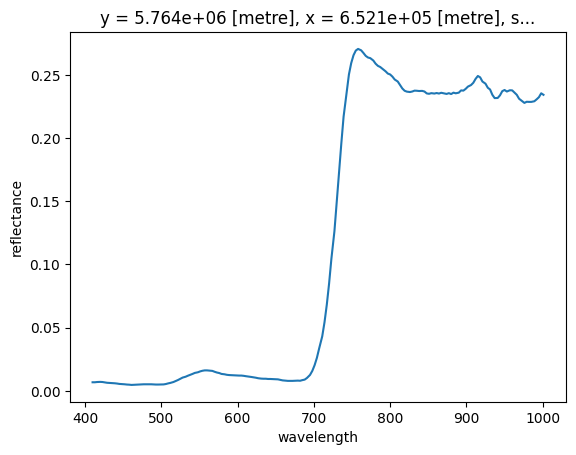

In [15]:
mk_vnir_reflectance.isel(y=10, x=10).plot()

Now we can carry out the SixS conversion to Top-Of-Atmosphere values:

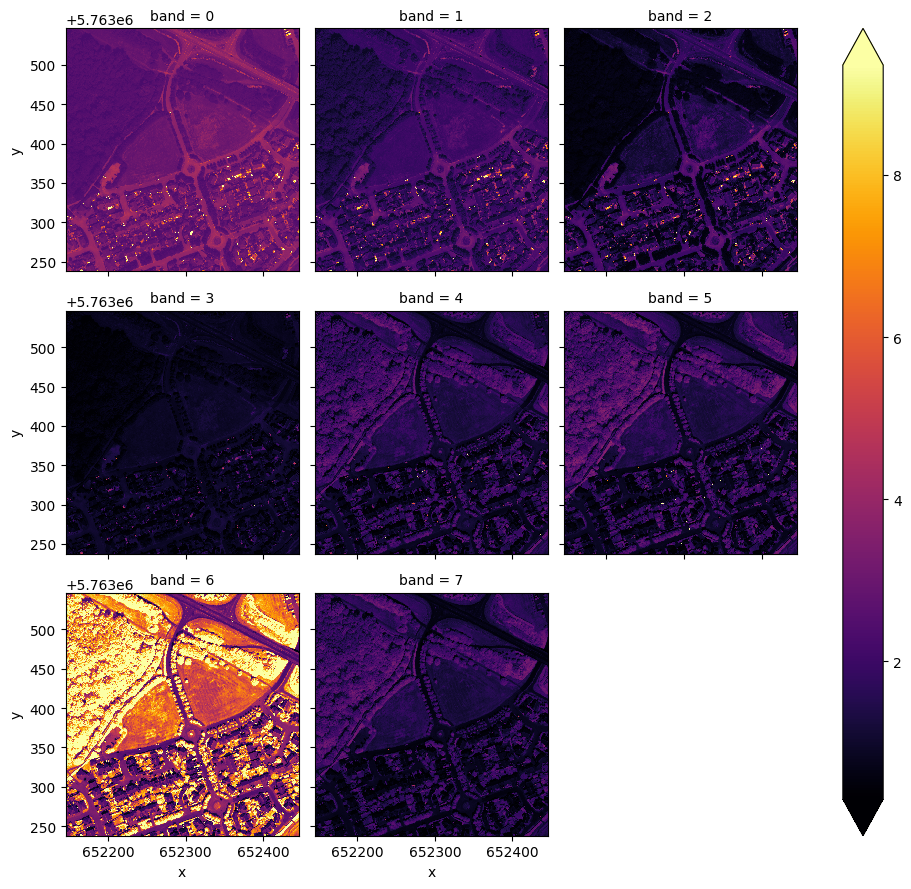

In [16]:
# use the atmosphere as a transformer
mk_vnir_toa = atmosphere_1.transform(mk_vnir_reflectance)

# plot this out
mk_vnir_toa.plot(col='band',col_wrap=3, robust=True, cmap='inferno')

The transformer has generated the total apparent radiance in each band for every pixel in the scene.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06406577254..10.203122050617706].


Text(0.5, 1.0, 'RGB composite')

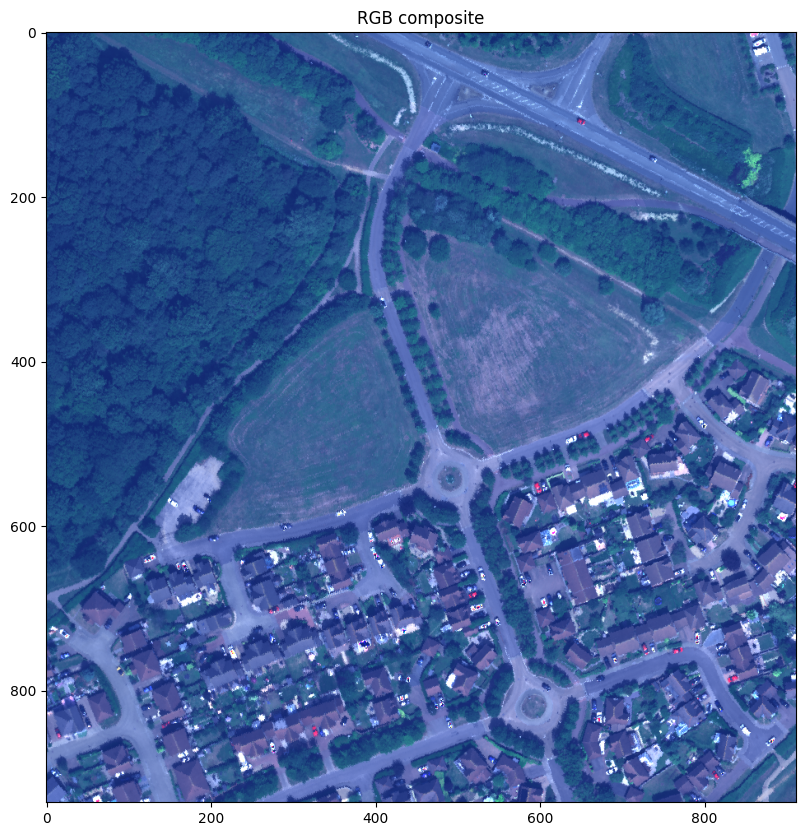

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(mk_vnir_toa.isel(band=[2,1,0]).values.transpose([1,2,0])/5)
plt.title('RGB composite')

The above composite has a slight blue tint because the atmosphere has a greater scattering effect in shorter wavelengths (Rayleigh Scattering) and so appears brighter in short wavelength bands.

### Suggested Activity:
Try altering the atmospheric properties and compare the results to our original (either by plotting or calculate the percentage difference)

In [18]:
## your solution here

<a id="imager"></a>
## 5. The TDI Imager

The imager is the final unit in the simulation and converts the at-sensor (top-of-atmosphere) radiance into a simulated Digital Number. There is specific information about the Sentinel 2 detector characterisation work here: https://core.ac.uk/download/pdf/12042569.pdf and I have used these values or estimated them for parameterising the sensor model below. For this example, we are using the line-scanning Time Delay Integration type imager.

In [19]:
from pyeosim import imager

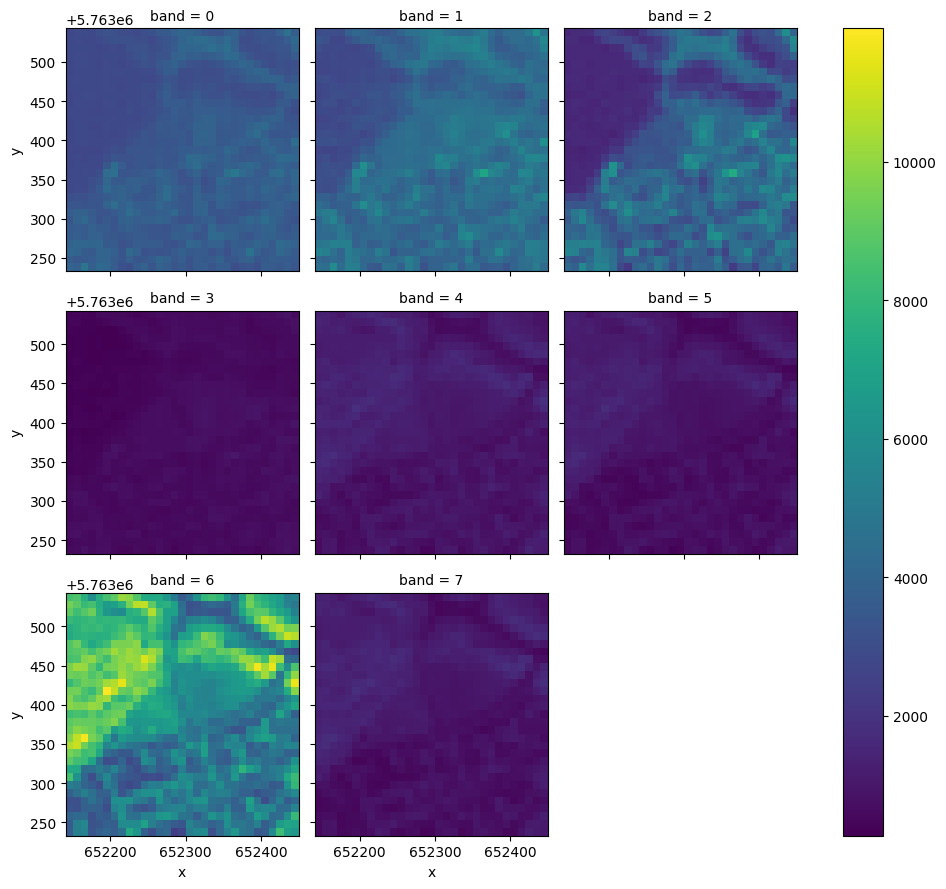

In [20]:
# Quantum Efficiencies per band
Sentinel2_Q_e = xarray.DataArray(
    [.67, .7, .71, .59, .5, .46, .3, .26],
    coords={'band': [0,1,2,3,4,5,6,7]}
)

# Conversion gain (microvolts/ electron) per band
Sentinel2_conversion_gain = xarray.DataArray(
    [3.5, 5.8, 6.1, 1.9, 2.1, 1.7, 4.4, 3.3],
    coords={'band': [0,1,2,3,4,5,6,7]}
)

# generate the 10m imager
imager10m = imager.TdiCmos(
    sensor_altitude=786000.0,
    sensor_ground_speed=75000,
    ground_sample_distance=10,
    lens_diameter=0.15,
    psf_fwhm=11, # estimate
    TDI_rows=10,
    pix_per_row=2596, 
    sensor_width=(2596*7.5)/1000, # estimate
    pixel_area=7.5**2,
    spectral_response=Sentinel2A_SRF,
    quantum_efficiency=Sentinel2_Q_e,
    full_well=100000, # estimate
    prnu_factor=0.01, # estimate
    dark_current=5, # estimate
    dark_factor=0.01, # estimate
    offset_factor=0.001, # estimate
    ccd_vref=3.1, # estimate
    sense_node_gain=Sentinel2_conversion_gain,
    read_noise=19,
    adc_vref=1, # fixed to 1 but may be adjusted
    bit_depth=14,
    store_steps=False,
    apply_spatial_resampling=True)

mk_vnir_DN = imager10m.fit_transform(mk_vnir_toa)
mk_vnir_DN.plot(col='band', col_wrap=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.22216666666666668..1.2248333333333334].


Text(0.5, 1.0, 'RGB composite')

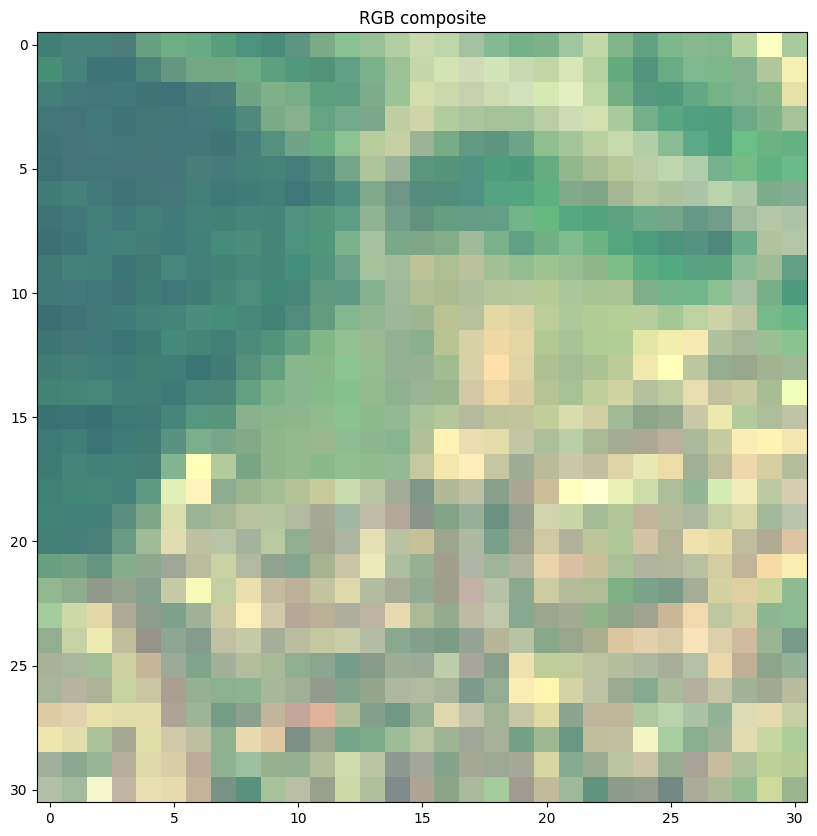

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(mk_vnir_DN.isel(band=[2,1,0]).values[:,::-1,:].transpose([1,2,0])/6000)
plt.title('RGB composite')

### The `steps` attribute

When the `transform()` method is called, the `imager.TdiCmos` carries out a sequence of transformations of the signal to convert the incoming radiance estimate to an output Digital Number. The `get_steps()` method shows these steps:

In [22]:
imager10m.get_steps()

['radiant energy to radiant flux',
 'apply spatial resampling',
 'radiant flux to flux density',
 'flux density to flux',
 'add photon shot noise',
 'photon to electron',
 'add photo response non-uniformity',
 'add dark signal',
 'electron to voltage',
 'add column offset noise',
 'voltage to DN']

The actual functions called are stored in a list (similar to the `sklearn.pipeline.Pipeline` class) and can be inspected or altered as require. For example the 'apply spatial resampling' step calls the 'gaussian_isotropic' using the psf_fwhm of 11m and a ground sampling distance of 10m:

In [23]:
print(imager10m.steps[1])

('apply spatial resampling', <function gaussian_isotropic at 0x155a6b880>, {'psf_fwhm': 11, 'ground_sample_distance': 10})


<br>

### Parameterising the `TdiCmos`
The table below has more information about each step for the default `TdiCmos`:
<br>

| Step                              | Expected Input                                          | Parameters [unit] (default value)                                                                 | Description                                                                                                                                                                                                                                                        | Output                                |
| --------------------------------- | ------------------------------------------------------- | ------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------- |
| Radiant Energy to Radiant Flux    | Radiant spectral energy<br>(W m-2 sr-1 band-1 micron-1) | None                                                                                              | Converts radiant energy to radiant flux using the central wavelength of the bandpass response.                                                                                                                                                                     | Spectral flux (photons m-2 sr-1)      |
| Apply Spatial Resampling          | Spectral flux<br>(photons m-2 sr-1 )                    | psf_fwhm [ground metres] (4)<br>ground_sample_distance [ground metres] (2)                        | Convolves the signal with the spatial response function and resamples to Ground Sampling Distance. The Point Spread Function Full Width at Half Maximum (psf_fwhm) is the 2D isotropic gaussian kernel width. This describes the overall blurriness of the system. | Spectral flux (photons m-2 sr-1 nm-1) |
| Radiant Flux to Flux Density      | Radiant spectral flux                                   | lens_diameter [m] (0.1)<br>focal_length [m] (2.57)                                                | Converts radiant flux to at-optic irradiance. Note that this does not account for the cos4 roll-off effect that occurs in most optical systems.                                                                                                                    | Irradiant spectral flux               |
| Flux Density to Flux              | Irradiant spectral flux                                 | Pixel_area [microns2] (100)<br>Integration_time [s] (0.0091)                                      | Converts flux density to (noiseless) photon count arriving at each pixel.                                                                                                                                                                                          | Photon count                          |
| Add Photon Shot Noise             | Photon count                                            | None                                                                                              | Draws a sample from a Poisson distribution where the mean is the expected photon count.                                                                                                                                                                            | Photon count                          |
| Photon to Electron                | Photon count                                            | Q_E [array] (1)                                                                                   | Multiplies the noisy count by the sensor quantum efficiency to get the electron count in the charge well.                                                                                                                                                          | Electron count                        |
| Add Photo Response Non-Uniformity | Electron count                                          | PRNU [array] (None)                                                                               | Adds photo-response non-uniformity noise. This is the inherent variability across the image plane and can either be specified with a map array or generated randomly as a zero-mean gaussian noise array.                                                          | Electron count                        |
| Add Dark Signal                   | Electron count                                          | dark_current [e-] (18240) integration_time [s] (0.0091)<br>dsnu [array] (None)                    | Draws a sample from a Poisson distribution where the mean is the expected electron count. The Dark Signal Non-Uniformity (DSNU) can also be specified here.                                                                                                        | Electron count                        |
| Electron to Voltage               | Electron count                                          | v_ref [V] (3.1)<br>sense_node_gain [V e-1] (5e-06) full_well [e-] (30000)<br>read_noise [e-] (20) | Converts electron count to voltage, adding in the sensor noise. The read noise is a singular noise value that incorporates reset noise and other noise sources from the front end electronics.                                                                     | Voltage                               |
| Add Column Offset Noise           | Voltage                                                 | Offset [array] (None)                                                                             | Variation in the silicon between columns mean that there is non-uniformity across the columns.                                                                                                                                                                     | Voltage                               |
| Voltage to DN                     | Voltage                                                 | v_ref [V] (0.5)<br>Bit_depth [int] (14)                                                           | Represents the digitiser converting the voltage to a digital signal.                                                                                                                                                                                               | digital numbers (DN)                  |

### Suggested Activity
Use [this paper](https://core.ac.uk/download/pdf/12042569.pdf) to try and produce the Sentinel-2A 20m bands.

You can do this by generating a new instance of the TdiCmos imager as above and changing the parameter values to those found in the paper.

In [24]:
## your code here

*End of Tutorial*